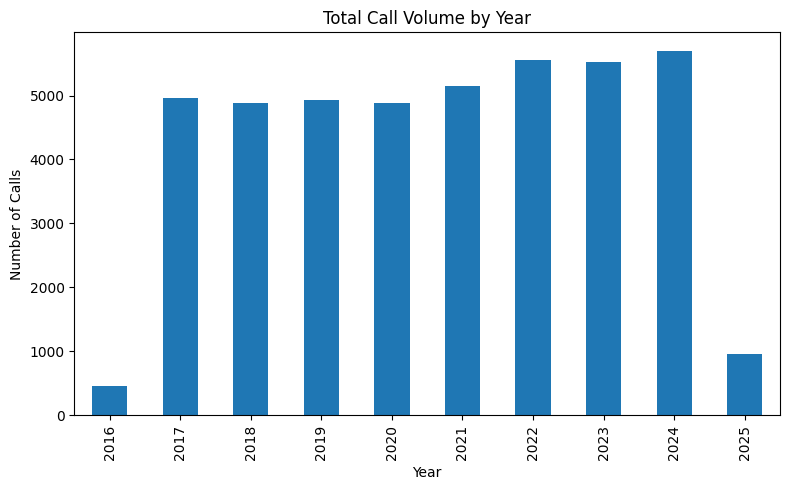

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/clean/calls_by_district_and_time_segment_with_year.csv")


# group by year and count the number of calls
calls_by_year = df.groupby('year').size()

# plot
plt.figure(figsize=(8, 5))
calls_by_year.plot(kind='bar')
plt.title('Total Call Volume by Year')
plt.xlabel('Year')
plt.ylabel('Number of Calls')
plt.tight_layout()
plt.show()

/var/folders/0z/d22cxjf5413996fwwtvz8s2c0000gn/T/ipykernel_63986/3252574578.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  call_counts = df.groupby(['weekday', 'time_segment']).size()
/var/folders/0z/d22cxjf5413996fwwtvz8s2c0000gn/T/ipykernel_63986/3252574578.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['weekday', 'time_segment']).size()


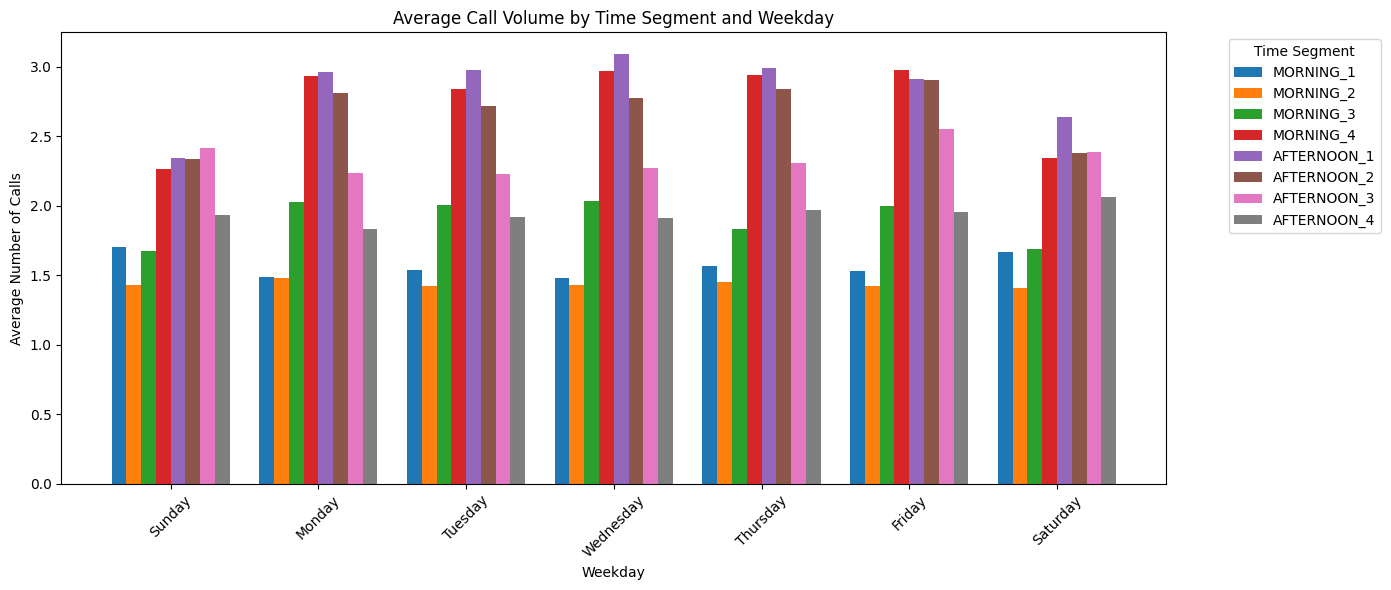

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# define the time segment and weekday order
time_order = ['MORNING_1', 'MORNING_2', 'MORNING_3', 'MORNING_4',
              'AFTERNOON_1', 'AFTERNOON_2', 'AFTERNOON_3', 'AFTERNOON_4']
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# ensure weekday is a categorical column in correct order
df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)
df['time_segment'] = pd.Categorical(df['time_segment'], categories=time_order, ordered=True)

# compute average number of calls per (weekday, time_segment)
# count total calls
call_counts = df.groupby(['weekday', 'time_segment']).size()

# count how many unique (weekday, time_segment) appearances exist (i.e., in how many weeks or days)
# assuming each row is a separate call, count how often each combo appears
combo_occurrences = df.drop_duplicates(subset=['year', 'week_of_year', 'weekday', 'time_segment']) \
    .groupby(['weekday', 'time_segment']).size()

# calculate average calls per combo
avg_calls = call_counts / combo_occurrences

# pivot to wide format for plotting
avg_counts = avg_calls.unstack(fill_value=0)

# reindex for full coverage
avg_counts = avg_counts.reindex(index=weekday_order, columns=time_order, fill_value=0)

# plot grouped bar chart
x = np.arange(len(weekday_order))  # base x positions for each weekday
width = 0.1  # width of each bar

plt.figure(figsize=(14, 6))

for i, segment in enumerate(time_order):
    plt.bar(x + i * width, avg_counts[segment], width=width, label=segment)

plt.xticks(x + width * 3.5, weekday_order, rotation=45)
plt.xlabel('Weekday')
plt.ylabel('Average Number of Calls')
plt.title('Average Call Volume by Time Segment and Weekday')
plt.legend(title='Time Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


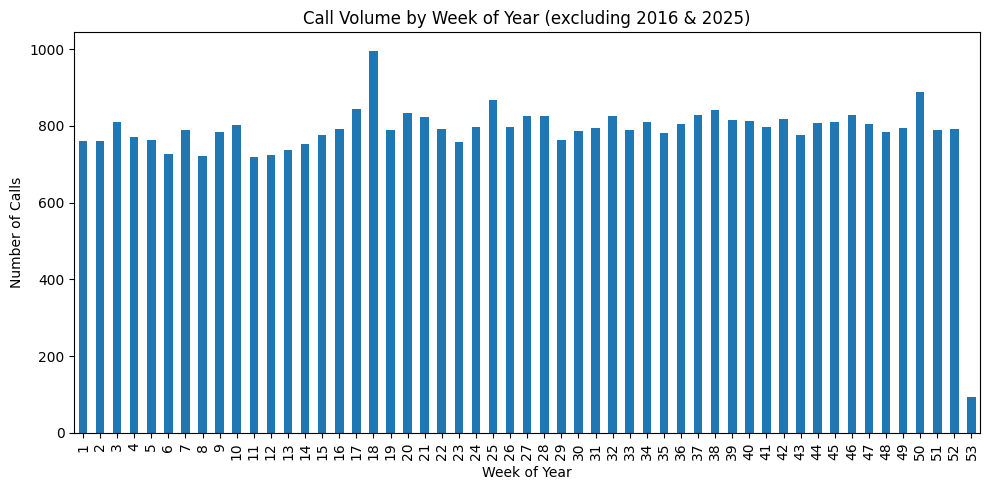

In [5]:
# filter out unwanted years
df_filtered = df[~df['year'].isin([2016, 2025])]

# group by week_of_year
calls_by_week = df_filtered.groupby('week_of_year').size().sort_index()

# plot
plt.figure(figsize=(10, 5))
calls_by_week.plot(kind='bar')
plt.title('Call Volume by Week of Year (excluding 2016 & 2025)')
plt.xlabel('Week of Year')
plt.ylabel('Number of Calls')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/var/folders/0z/d22cxjf5413996fwwtvz8s2c0000gn/T/ipykernel_63986/416745304.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby(['week_of_year', 'weekday']).size()


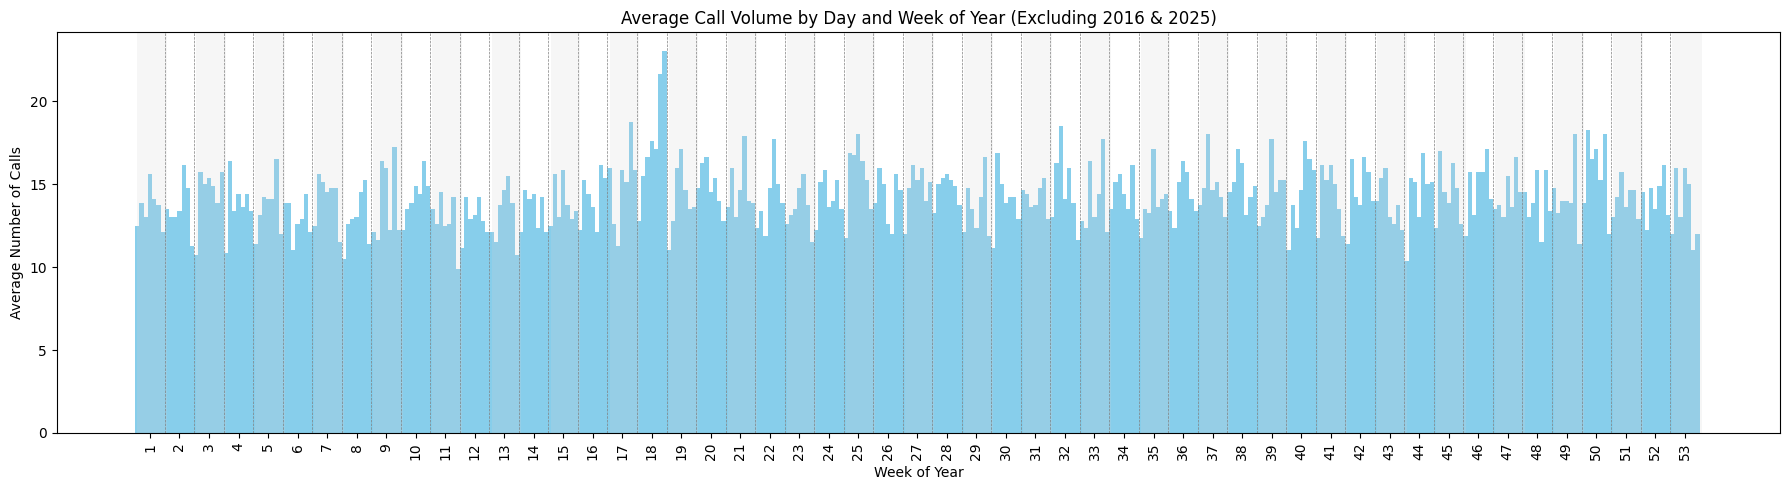

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# filter out 2016 and 2025
df_filtered = df[~df['year'].isin([2016, 2025])]

# enforce consistent weekday order
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_filtered['weekday'] = pd.Categorical(df_filtered['weekday'], categories=weekday_order, ordered=True)

# count how many years exist per week_of_year
week_years = df_filtered.groupby(['week_of_year', 'year']).ngroup()
df_filtered['week_year_id'] = df_filtered['week_of_year'].astype(str) + '-' + df_filtered['year'].astype(str)

# average number of calls per (week_of_year, weekday)
counts = df_filtered.groupby(['week_of_year', 'weekday']).size()
week_counts = df_filtered.groupby(['week_of_year', 'year']).ngroups  # number of unique (week, year) combos

# pivot into a DataFrame and normalize by number of years that contain each week
counts_df = counts.unstack(fill_value=0)

# compute how many distinct years contribute to each week_of_year
week_to_years = df_filtered.groupby('week_of_year')['year'].nunique()
averaged_counts = counts_df.divide(week_to_years, axis=0)

# ensure full 7-day coverage per week
averaged_counts = averaged_counts.reindex(columns=weekday_order, fill_value=0)

# flatten to 1D array
flattened_counts = averaged_counts.values.flatten()

# build x-axis labels
week_labels = averaged_counts.index
x_labels = []
for week in week_labels:
    for day in weekday_order:
        x_labels.append(f'{week}-{day[:3]}')

# plot
plt.figure(figsize=(18, 5))
plt.bar(range(len(flattened_counts)), flattened_counts, width=1.0, color='skyblue')

# add vertical lines every 7 bars
for i in range(7, len(flattened_counts), 7):
    plt.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=0.5)

# shade alternating weeks
for i in range(0, len(flattened_counts) // 7, 2):
    plt.axvspan(i * 7, (i + 1) * 7, facecolor='lightgray', alpha=0.2)

# sparse tick labels centered per week
plt.xticks(
    ticks=np.arange(3, len(flattened_counts), 7),
    labels=week_labels,
    rotation=90
)

plt.title('Average Call Volume by Day and Week of Year (Excluding 2016 & 2025)')
plt.xlabel('Week of Year')
plt.ylabel('Average Number of Calls')
plt.tight_layout()
plt.show()


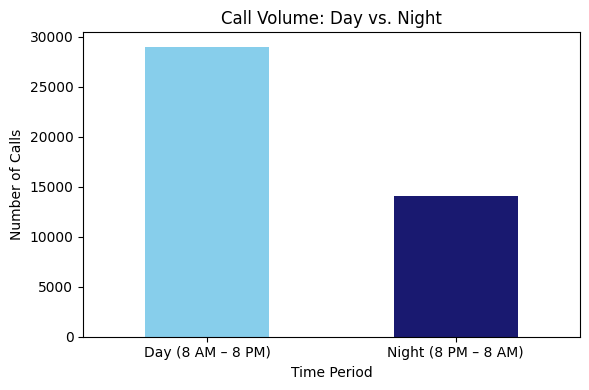

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# load the CSV
df_full = pd.read_csv('../data/clean/calls_full.csv')

# convert CallDateTime to datetime
df_full['CallDateTime'] = pd.to_datetime(df_full['CallDateTime'])

# extract hour
df_full['hour'] = df_full['CallDateTime'].dt.hour

# assign period (8 AM – 8 PM is day; else night)
df_full['period'] = df_full['hour'].apply(lambda h: 'Day (8 AM – 8 PM)' if 8 <= h < 20 else 'Night (8 PM – 8 AM)')

# count calls by period
period_counts = df_full['period'].value_counts().reindex(['Day (8 AM – 8 PM)', 'Night (8 PM – 8 AM)'], fill_value=0)

# plot
plt.figure(figsize=(6, 4))
period_counts.plot(kind='bar', color=['skyblue', 'midnightblue'])
plt.title('Call Volume: Day vs. Night')
plt.xlabel('Time Period')
plt.ylabel('Number of Calls')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


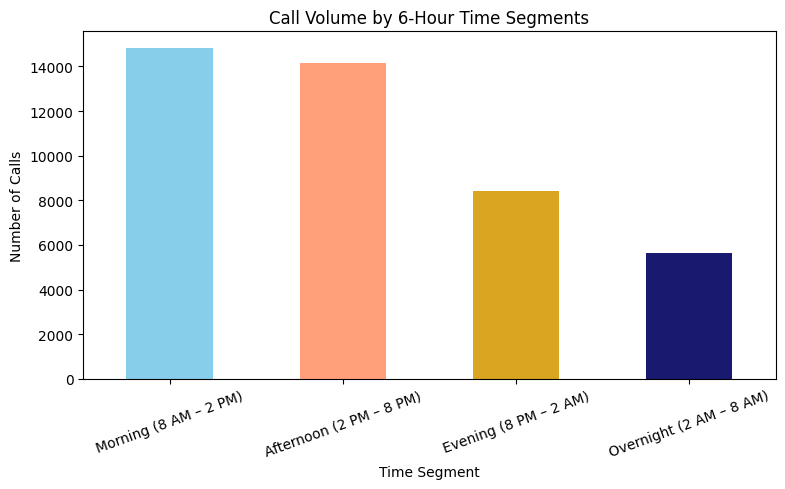

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# load data
df_full = pd.read_csv('../data/clean/calls_full.csv')
df_full['CallDateTime'] = pd.to_datetime(df_full['CallDateTime'])

# extract hour
df_full['hour'] = df_full['CallDateTime'].dt.hour

# define the four time segments (8 AM shift start)
def map_time_segment(hour):
    if 8 <= hour < 14:
        return 'Morning (8 AM – 2 PM)'
    elif 14 <= hour < 20:
        return 'Afternoon (2 PM – 8 PM)'
    elif 20 <= hour or hour < 2:
        return 'Evening (8 PM – 2 AM)'
    else:
        return 'Overnight (2 AM – 8 AM)'

df_full['period'] = df_full['hour'].apply(map_time_segment)

# count number of calls per period
period_counts = df_full['period'].value_counts().reindex([
    'Morning (8 AM – 2 PM)',
    'Afternoon (2 PM – 8 PM)',
    'Evening (8 PM – 2 AM)',
    'Overnight (2 AM – 8 AM)'
], fill_value=0)

# plot
plt.figure(figsize=(8, 5))
period_counts.plot(kind='bar', color=['skyblue', 'lightsalmon', 'goldenrod', 'midnightblue'])
plt.title('Call Volume by 6-Hour Time Segments')
plt.xlabel('Time Segment')
plt.ylabel('Number of Calls')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


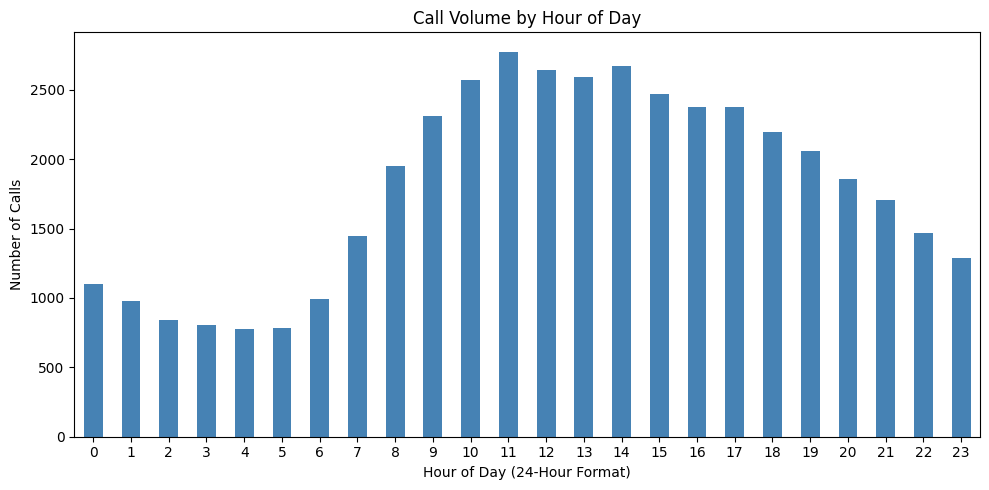

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# load and parse datetime
df_full = pd.read_csv('../data/clean/calls_full.csv')
df_full['CallDateTime'] = pd.to_datetime(df_full['CallDateTime'])

# extract hour
df_full['hour'] = df_full['CallDateTime'].dt.hour

# count calls per hour
hourly_counts = df_full['hour'].value_counts().sort_index()

# ensure all 24 hours are represented (fill missing with 0)
hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# plot
plt.figure(figsize=(10, 5))
hourly_counts.plot(kind='bar', color='steelblue')
plt.title('Call Volume by Hour of Day')
plt.xlabel('Hour of Day (24-Hour Format)')
plt.ylabel('Number of Calls')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


8:00 am to 8:00 pm is the most busy 12 hour segment of the day

<Figure size 1400x600 with 0 Axes>

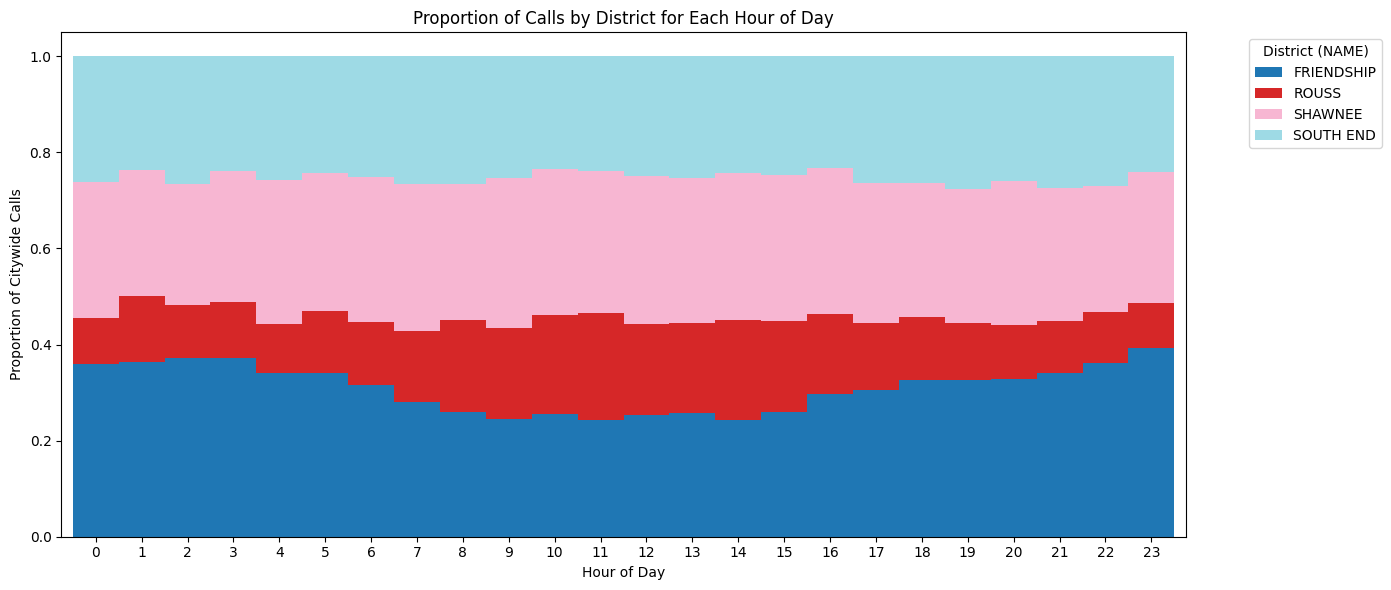

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# load full data
df_full = pd.read_csv('../data/clean/calls_by_district.csv')
df_full['CallDateTime'] = pd.to_datetime(df_full['CallDateTime'])
df_full['hour'] = df_full['CallDateTime'].dt.hour

# group by hour and district (NAME), count calls
hourly_district_counts = df_full.groupby(['hour', 'NAME']).size().unstack(fill_value=0)

# compute proportions
hourly_proportions = hourly_district_counts.div(hourly_district_counts.sum(axis=1), axis=0)

# plot
plt.figure(figsize=(14, 6))
hourly_proportions.plot(kind='bar', stacked=True, colormap='tab20', width=1.0, figsize=(14, 6))

plt.title('Proportion of Calls by District for Each Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion of Citywide Calls')
plt.legend(title='District (NAME)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


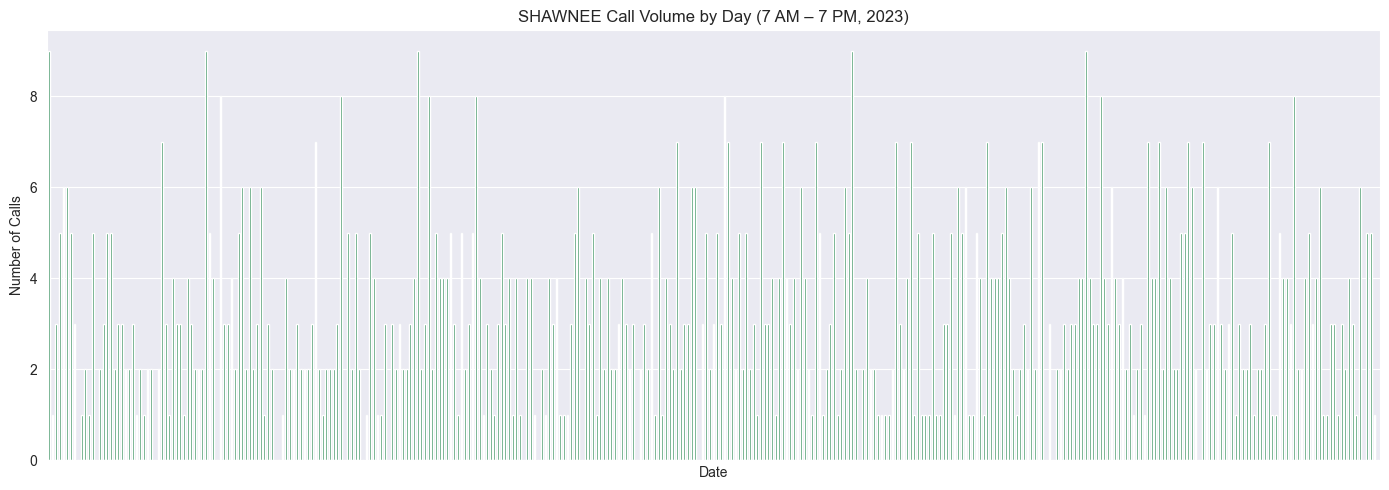

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load data
df = pd.read_csv('../data/clean/calls_by_district.csv')
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])

# filter for SHAWNEE, 2023, and 7:00 AM to 7:00 PM
df = df[
    (df['NAME'] == 'SHAWNEE') &
    (df['CallDateTime'].dt.year == 2023) &
    (df['CallDateTime'].dt.hour >= 7) &
    (df['CallDateTime'].dt.hour < 19)
    ]

# extract date
df['date'] = df['CallDateTime'].dt.date

# actual call counts
daily_counts = df.groupby('date').size()

# create full date range for 2023
full_dates = pd.date_range(start='2023-01-01', end='2023-12-31')
full_dates = pd.Series(0, index=full_dates.date)

# combine with actual counts
complete_counts = full_dates.add(daily_counts, fill_value=0).astype(int)

# plot
plt.figure(figsize=(14, 5))
complete_counts.plot(kind='bar', color='seagreen')
plt.title('SHAWNEE Call Volume by Day (7 AM – 7 PM, 2023)')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.xticks([], [])  # suppress individual date ticks for readability
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# load and prepare data
df = pd.read_csv('../data/clean/calls_by_district.csv')
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df['year'] = df['CallDateTime'].dt.year
df['week'] = df['CallDateTime'].dt.isocalendar().week
df['weekday'] = df['CallDateTime'].dt.day_name()
df['date'] = df['CallDateTime'].dt.date

# filter to 2017–2022
df = df[(df['year'] >= 2017) & (df['year'] <= 2022)]

# count calls per district per (week, weekday, year)
grouped = df.groupby(['week', 'weekday', 'year', 'NAME']).size().unstack(fill_value=0)

# normalize to proportions (district-level call share per day)
grouped_prop = grouped.div(grouped.sum(axis=1), axis=0)

# group by (week, weekday) to compare proportions across years
results = []
for (week, weekday), group in grouped_prop.groupby(level=[0, 1]):
    if group.shape[0] < 2:
        continue  # need at least two years to compare

    vectors = group.values  # rows = years, columns = districts
    similarities = []

    # compare each year-to-year pair
    for i, j in combinations(range(len(vectors)), 2):
        sim = cosine_similarity([vectors[i]], [vectors[j]])[0, 0]
        similarities.append(sim)

    avg_sim = np.mean(similarities)
    results.append({'week': week, 'weekday': weekday, 'avg_cosine_similarity': avg_sim})

# convert to DataFrame
similarity_df = pd.DataFrame(results)

# optional: show most and least consistent weekday/week combos
# print(similarity_df.sort_values('avg_cosine_similarity', ascending=False).head(1000))
# print(similarity_df['avg_cosine_similarity'].mean())

similarity_df.sort_values('avg_cosine_similarity', ascending=False).head(1000)

,week,weekday,avg_cosine_similarity
281,41,Monday,0.941687
301,44,Friday,0.937021
120,18,Monday,0.933208
38,6,Sunday,0.932856
35,6,Friday,0.930550
...,...,...,...
256,37,Thursday,0.690497
94,14,Sunday,0.686331
55,8,Wednesday,0.655805
72,11,Saturday,0.645616
